# How to Train Brain-Inspired Model?

**Goal**: By the end of this guide, you'll be able to train a Hopfield network to store and recall patterns using Hebbian learning.

**Estimated Reading Time**: 12 minutes

---

## Introduction

Unlike deep learning models trained with backpropagation, **brain-inspired models** use biologically plausible learning rules like **Hebbian learning**:

> *"Neurons that fire together, wire together."* — Donald Hebb (1949)

This guide introduces:
1. The Hebbian learning principle
2. Training a Hopfield network for pattern memory
3. Using the Trainer framework
4. Key differences from deep learning

We'll train a model to memorize and recall images—demonstrating associative memory in action.

## What is Hebbian Learning?

**Hebbian learning** is an unsupervised learning rule where synaptic weights strengthen when pre- and post-synaptic neurons are co-active:

```
Δw_ij = η × x_i × x_j
```

Where:
- `w_ij`: Connection weight from neuron `i` to neuron `j`
- `x_i, x_j`: Activities of neurons `i` and `j`
- `η`: Learning rate (often set to 1 for simple rules)

**Key properties**:
- **Local**: Weight updates depend only on activities of connected neurons (no global error signal)
- **Unsupervised**: No labels or target outputs required
- **Biologically plausible**: Matches synaptic plasticity observed in real neurons

**Contrast with backpropagation**:
- Backprop: Global error signal, supervised, requires differentiable loss
- Hebbian: Local activity, unsupervised, no gradient computation

## The Hopfield Network

An **Amari-Hopfield Network** is a recurrent network that stores patterns as stable attractor states. When presented with a partial or noisy pattern, the network converges to the nearest stored memory.

**Use case**: Associative memory, pattern completion, error correction

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork

# Create a Hopfield network with 16,384 neurons (128x128 flattened image)
model = AmariHopfieldNetwork(
    num_neurons=128 * 128,  # Image size when flattened
    asyn=False,             # Synchronous updates (all neurons update together)
    activation="sign"       # Binary activation: +1 or -1
)

**Parameters**:
- `num_neurons`: Network size (must match input dimensionality)
- `asyn`: Asynchronous (one neuron at a time) vs synchronous updates
- `activation`: "sign" for binary Hopfield, "tanh" for continuous variant

## The Trainer Framework

The library provides a **unified Trainer API** that abstracts training logic:

```
Model + Trainer + Data → Trained Model
```

**Philosophy** (from the Design Philosophy docs):
- **Separation of concerns**: Model defines dynamics, Trainer defines learning
- **Reusability**: Same trainer works for different models with compatible learning rules
- **Composability**: Stack trainers for multi-stage training

For Hebbian learning, we use `HebbianTrainer`:

In [2]:
from canns.trainer import HebbianTrainer

trainer = HebbianTrainer(model)

**Key methods**:
- `trainer.train(data)`: Train on a list of patterns
- `trainer.predict(pattern)`: Recall a single pattern
- `trainer.predict_batch(patterns)`: Batch recall (compiled for speed)

## Complete Example: Image Memory

Let's train a Hopfield network to memorize 4 images and recall them from corrupted versions.

### Step 1: Prepare Training Data

In [4]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean

def preprocess_image(img, size=128):
    """Convert image to binary {-1, +1} pattern."""
    # Convert to grayscale if needed
    if img.ndim == 3:
        img = rgb2gray(img)

    # Resize to fixed size
    img = resize(img, (size, size), anti_aliasing=True)

    # Threshold to binary
    thresh = threshold_mean(img)
    binary = img > thresh

    # Map to {-1, +1}
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)

    # Flatten to 1D
    return pattern.reshape(size * size)

# Load example images from scikit-image
camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

print(f"Number of patterns: {len(training_data)}")
print(f"Pattern shape: {training_data[0].shape}")  # (16384,) = 128*128

Number of patterns: 4
Pattern shape: (16384,)


**Why binary {-1, +1}?**
- Classic Hopfield networks use binary neurons
- Simplifies the energy function and update rules
- Real-valued extensions exist (use `activation="tanh"`)

### Step 2: Create Model and Trainer

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# Create Hopfield network (auto-initializes)
model = AmariHopfieldNetwork(
    num_neurons=training_data[0].shape[0],
    asyn=False,
    activation="sign"
)

# Create Hebbian trainer
trainer = HebbianTrainer(model)

print("Model and trainer initialized!")

### Step 3: Train the Model

In [6]:
# Train on all patterns (this computes Hebbian weight matrix)
trainer.train(training_data)

print("Training complete! Patterns stored in weights.")

Training complete! Patterns stored in weights.


**What happened internally**:

In [ ]:
# Simplified version of Hebbian weight update
for pattern in training_data:
    W += np.outer(pattern, pattern)  # Hebbian: w_ij += x_i * x_j
W /= len(training_data)  # Normalize
np.fill_diagonal(W, 0)   # No self-connections

The weight matrix `W` now encodes all training patterns as attractor states.

### Step 4: Test Pattern Recall

Create corrupted versions of the training images:

In [8]:
def corrupt_pattern(pattern, noise_level=0.3):
    """Randomly flip 30% of pixels."""
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1  # Flip sign
    return corrupted

# Create test patterns (30% corrupted)
test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

print(f"Created {len(test_patterns)} corrupted test patterns")

Created 4 corrupted test patterns


### Step 5: Recall Patterns

In [9]:
# Batch prediction (compiled for efficiency)
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

print("Pattern recall complete!")
print(f"Recalled patterns shape: {np.array(recalled).shape}")

Processing samples: 100%|█████████████| 4/4 [00:03<00:00,  1.13it/s, sample=4/4]


Pattern recall complete!
Recalled patterns shape: (4, 16384)


**What's happening**:
- For each corrupted pattern, the network iterates its dynamics
- The activity converges to the nearest stored attractor (original image)
- The result is the "cleaned up" pattern

### Step 6: Visualize Results

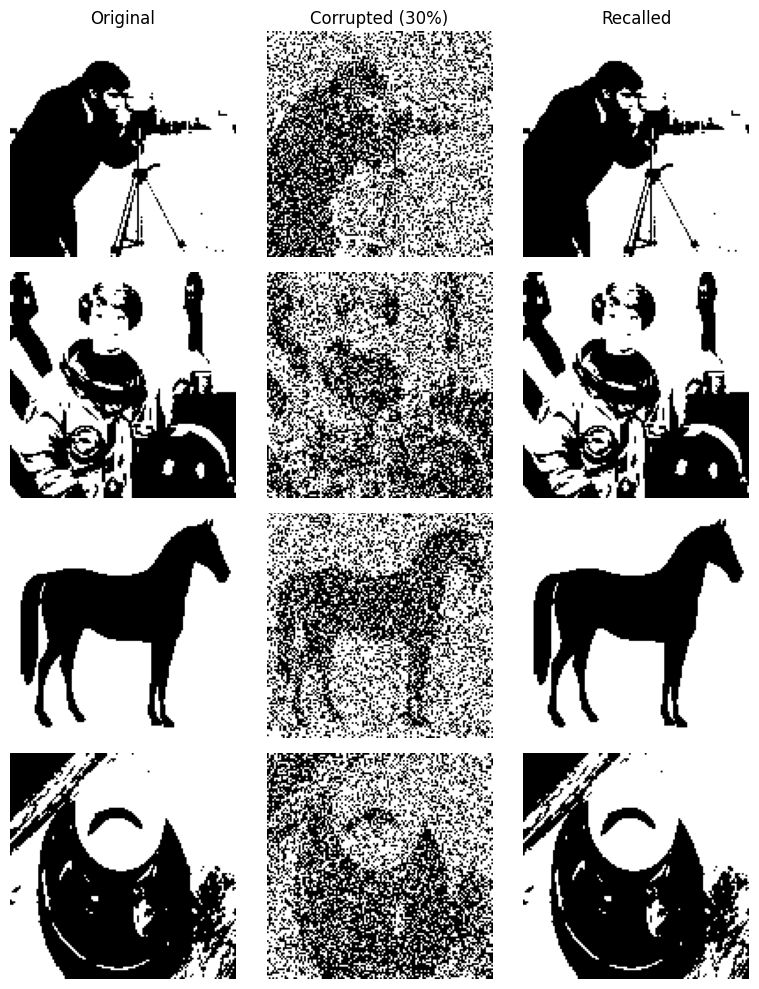

Visualization saved!


In [10]:
import matplotlib.pyplot as plt

def reshape_for_display(pattern, size=128):
    """Reshape 1D pattern back to 2D image."""
    return pattern.reshape(size, size)

# Plot original, corrupted, and recalled patterns
fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))

for i in range(len(training_data)):
    # Column 1: Original training image
    axes[i, 0].imshow(reshape_for_display(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('Original')

    # Column 2: Corrupted test input
    axes[i, 1].imshow(reshape_for_display(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('Corrupted (30%)')

    # Column 3: Recalled output
    axes[i, 2].imshow(reshape_for_display(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_memory_recall.png', dpi=150)
plt.show()

print("Visualization saved!")

**Expected result**:
- Original images are clean
- Corrupted inputs have ~30% noise
- Recalled outputs match originals (noise corrected!)

## Complete Runnable Code

Here's the full example in one block:

In [ ]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean
from matplotlib import pyplot as plt

from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

np.random.seed(42)

# 1. Preprocess images
def preprocess_image(img, size=128):
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, (size, size), anti_aliasing=True)
    thresh = threshold_mean(img)
    binary = img > thresh
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)
    return pattern.reshape(size * size)

camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

# 2. Create model and trainer (auto-initializes)
model = AmariHopfieldNetwork(num_neurons=training_data[0].shape[0], asyn=False, activation="sign")
trainer = HebbianTrainer(model)

# 3. Train
trainer.train(training_data)

# 4. Create corrupted test patterns
def corrupt_pattern(pattern, noise_level=0.3):
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1
    return corrupted

test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

# 5. Recall patterns
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

# 6. Visualize
def reshape(pattern, size=128):
    return pattern.reshape(size, size)

fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))
for i in range(len(training_data)):
    axes[i, 0].imshow(reshape(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(reshape(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(reshape(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')

axes[0, 0].set_title('Original')
axes[0, 1].set_title('Corrupted')
axes[0, 2].set_title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_memory.png')
plt.show()

## CANN vs. Deep Learning Training

| Aspect | CANNs / Hebbian Learning | Deep Learning (ANNs) |
|--------|-------------------------|----------------------|
| **Learning rule** | Local (Hebbian, STDP) | Global (Backpropagation) |
| **Supervision** | Unsupervised | Supervised (usually) |
| **Gradient** | No gradient computation | Requires autodiff |
| **Training data** | Patterns to memorize | Labeled input-output pairs |
| **Objective** | Form attractors | Minimize loss function |
| **Biological plausibility** | High | Low |
| **Speed** | Fast (one-shot learning possible) | Slow (many epochs) |
| **Capacity** | Limited (~0.15N patterns for N neurons) | Very large (overparameterization) |

**When to use each**:
- **Hebbian/CANNs**: Associative memory, pattern completion, neuroscience modeling
- **Backprop/ANNs**: Classification, regression, large-scale pattern recognition

## The Trainer Abstraction

The `Trainer` framework provides a consistent interface across different learning paradigms:

In [ ]:
# All trainers follow this pattern
trainer = SomeTrainer(model)
trainer.train(data)
output = trainer.predict(input)

**Available trainers**:
- `HebbianTrainer`: Hebbian learning (as shown here)
- Future trainers: STDP, BCM, reinforcement learning, etc.

**Why this design?**
- **Modularity**: Swap learning rules without changing model code
- **Consistency**: Same API for different learning algorithms
- **Extensibility**: Easy to add custom trainers

See the Design Philosophy docs for more details on this architecture.

## Next Steps

Congratulations! You've trained a brain-inspired model using Hebbian learning. Now explore:

1. **[Core Concepts](link-to-core-concepts)** - Deepen your understanding of all library components
2. **[Brain-Inspired Training](link-to-core-concepts-training)** - Learn about other learning rules (STDP, BCM, etc.)
3. **[Full Trainer API](link-to-full-details-training)** - Complete reference for all trainers and training methods

---

**Quick Reference**:

In [ ]:
# Hebbian training template
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# Create model (auto-initializes)
model = AmariHopfieldNetwork(num_neurons=N, activation="sign")

# Create trainer
trainer = HebbianTrainer(model)

# Train on patterns
trainer.train([pattern1, pattern2, ...])

# Recall
output = trainer.predict(noisy_input)

---

*Questions? Check the [Trainer Framework Guide](link-to-core-concepts-trainer) or [GitHub Discussions](https://github.com/routhleck/canns/discussions).*